## Libraries

In [ ]:
import numpy as np
import pandas as pd
from random import gauss
import statistics
import random
import copy
import math
import sys
from numpy import asarray
from numpy import exp
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed
import matplotlib.pyplot as plt

In [ ]:
!pip install deap

     |████████████████████████████████| 160 kB 5.3 MB/s 


In [ ]:
from deap.benchmarks import *

In [ ]:
!pip install geneticalgorithm
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

     |████████████████████████████████| 44 kB 1.8 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15098 sha256=51112358d2a162a23719c3de81d45b0533a050c4460ba1addca3ba65be214ad3
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
Successfully built func-timeout


In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## WHO

In [ ]:
def create_population(pop_size,lowerb,upperb,dim=20):
  population = np.random.uniform(lowerb,upperb,dim*pop_size).reshape(-1,dim)
  return population
def rastrigin(x):
  try:
    n = len(x)
  except:
    n=1  
  return 10*n+np.sum(x**2-10*np.cos(2*np.pi*x))

def schwefel(x):
  try:
    n = len(x)
  except:
    n=1 
  return 418.9829*n - np.sum(x*np.sin(np.sqrt(np.abs(x))))
def griewangk(x):
  try:
    i=np.array([i for i in range(len(x))])
    return 1+np.sum((x**2)/4000)-np.product(np.cos(x/np.sqrt(i)))
  except:  
    i=np.array([1])
    return 1+np.sum((x**2)/4000)-np.product(np.cos(x/np.sqrt(i))) 
def sphere1(x):
  return sphere(x)[0]

def mean(data):
    """Return the sample arithmetic mean of data."""
    n = len(data)
    if n < 1:
        raise ValueError('mean requires at least one data point')
    return sum(data)/n # in Python 2 use sum(data)/float(n)


In [ ]:
def make_rand_unit_vector(dim):
    vec = [0]*dim
    vec[random.randint(0,dim-1)]=1
    return np.array(vec)

In [ ]:

def calculate_fitnesses(population,function='rastrigin'):
  cp = []
  for i,p in enumerate(population):
    cp.append(fitness(p,function))
  return np.array(cp)     
def fitness(x,function='rastrigin'):
  if function == 'rastrigin':
    return rastrigin(x)  
  elif function=='ackley':
    return ackley(x)  
  elif function=='weierstrass':
    return weierstrass(x)  
  elif function=='sphere':
    # print(sphere(x))
    return sphere(x)[0]  


In [ ]:
def local_movement(xp_cp_dataframe,ns,argmin_star,c_p_star,alpha1,betta1,dim,function='rastrigin'):
  for idx,row in xp_cp_dataframe.iterrows():
    xp=row['x_p']
    cp=row['c_p']
    df = pd.DataFrame(columns=['y_s','c_s'])
    for s in range(ns):
      # print(xp.shape,make_rand_unit_vector(dim).shape)
      y_s= xp+etha*make_rand_unit_vector(dim)
      # print(function)
      c_s= fitness(y_s,function)
      df.loc[len(df)]=[y_s,c_s]
    # print(df)  
    argmin=df['c_s'].idxmin() 
    s_star=df['y_s'].loc[argmin]
    xp=alpha1*s_star+betta1*(xp-s_star)
    xp_cp_dataframe.at[idx,'x_p']=xp
    cp=fitness(xp,function)
    xp_cp_dataframe.at[idx,'c_p']=cp
    if cp < c_p_star:
      argmin_star=idx
      c_p_star=cp
  return xp_cp_dataframe,argmin_star,c_p_star      


In [ ]:
def herd_distinction(xp_cp_dataframe,argmin_star,c_p_star,ph,alpha2,betta2,function='rastrigin'):
  for idx,row in xp_cp_dataframe.iterrows():
    xp=row['x_p']
    cp=row['c_p']
    h=np.random.randint(0,len(xp_cp_dataframe))
    xh=xp_cp_dataframe['x_p'].loc[h]
    ch=xp_cp_dataframe['c_p'].loc[h]
    u = np.random.uniform(0,1)
    if ch<cp and u<ph:
      xp=alpha2*xp+betta2*xh
      cp=fitness(xp,function)
      xp_cp_dataframe.at[idx,'x_p']=xp
      xp_cp_dataframe.at[idx,'c_p']=cp
    if cp < c_p_star:
      argmin_star=idx
      c_p_star=cp
  return xp_cp_dataframe,argmin_star,c_p_star       





In [ ]:
def starvation_avoidance(xp_cp_dataframe,x_worst,dim,etha,distance_from_crowding_threshold,distance_from_worst_threshold,ne,function='rastrigin'):
  argmin_star=xp_cp_dataframe['c_p'].idxmin()
  cp_star=xp_cp_dataframe['c_p'].loc[argmin_star] 
  for idx,row in xp_cp_dataframe.iterrows():
    xp=row['x_p']
    cp=row['c_p']    
    x_min=xp_cp_dataframe['x_p'].loc[argmin_star]
    argmax=xp_cp_dataframe['c_p'].idxmax()
    x_max=xp_cp_dataframe['x_p'].loc[argmax]
    dist= np.linalg.norm((xp-x_worst))
    # print( dist)
    if dist< distance_from_worst_threshold:
      xp=xp+np.random.uniform(0,1)*(x_max-x_min)*make_rand_unit_vector(dim)
      cp=fitness(xp,function)
      xp_cp_dataframe.at[idx,'x_p']=xp
      xp_cp_dataframe.at[idx,'c_p']=cp
      if cp<cp_star:
        argmin_star=idx
        cp_star=cp
    dist2 = np.linalg.norm((x_min-xp)) 
    if dist2<distance_from_crowding_threshold and dist2>1:
      xp=x_min+etha*np.ones(x_min.size)#n vec
      cp=fitness(xp,function)
      xp_cp_dataframe.at[idx,'x_p']=xp
      xp_cp_dataframe.at[idx,'c_p']=cp
      if cp<cp_star:
        argmin_star=idx
        cp_star=cp

    for _ in range(ne):
      x=x_min+.1*make_rand_unit_vector(dim)
      c=fitness(x,function)
      argmin_star=xp_cp_dataframe['c_p'].idxmin()
      cp_star=xp_cp_dataframe['c_p'].loc[argmin_star]
      if c<cp_star:
        cp_star=c
        xp_cp_dataframe.at[argmin_star,'x_p']=x
        xp_cp_dataframe.at[argmin_star,'c_p']=c

  return xp_cp_dataframe,argmin_star,cp_star

  

In [ ]:
def wildbeast_optimizaiton(xp_cp_dataframe,ns,dim,etha,distance_from_crowding_threshold,distance_from_worst_threshold,ne,ph,alpha1,betta1,alpha2,betta2,function='rastrigin'):
  argmin_star=xp_cp_dataframe['c_p'].idxmin() 
  c_p_star=xp_cp_dataframe['c_p'].loc[argmin_star]
  best_fitness_list=[]
  for i in range(max_iteration):
    if i%100==0:
      print(f"iteration # {i}")
    xp_cp_dataframe,argmin_star,c_p_star = local_movement(xp_cp_dataframe,ns,argmin_star,c_p_star,alpha1,betta1,dim,function)
    xp_cp_dataframe,argmin_star,c_p_star = herd_distinction(xp_cp_dataframe,argmin_star,c_p_star,ph,alpha2,betta2,function)
    argmax_star=xp_cp_dataframe['c_p'].idxmax() 
    x_worst=xp_cp_dataframe['x_p'].loc[argmax_star]
    xp_cp_dataframe,argmin_star,cp_star = starvation_avoidance(xp_cp_dataframe,x_worst,dim,etha,distance_from_crowding_threshold,distance_from_worst_threshold,ne,function)
    best_fitness_list.append(cp_star)
  return best_fitness_list

## pso

In [ ]:

class Particle:
  def __init__(self, fitness, dim, minx, maxx, seed):
    self.rnd = random.Random(seed)
 
    # initialize position of the particle with 0.0 value
    self.position = [0.0 for i in range(dim)]
 
     # initialize velocity of the particle with 0.0 value
    self.velocity = [0.0 for i in range(dim)]
 
    # initialize best particle position of the particle with 0.0 value
    self.best_part_pos = [0.0 for i in range(dim)]
 
    # loop dim times to calculate random position and velocity
    # range of position and velocity is [minx, max]
    for i in range(dim):
      self.position[i] = ((maxx - minx) *
        self.rnd.random() + minx)
      self.velocity[i] = ((maxx - minx) *
        self.rnd.random() + minx)
 
    # compute fitness of particle
    self.fitness = fitness(self.position) # curr fitness
 
    # initialize best position and fitness of this particle
    self.best_part_pos = copy.copy(self.position)
    self.best_part_fitnessVal = self.fitness # best fitness
 
# particle swarm optimization function
def pso(fitness, max_iter, n, dim, minx, maxx,w=.4,c1=1.5,c2=2.4):
 
  rnd = random.Random(0)
 
  # create n random particles
  swarm = [Particle(fitness, dim, minx, maxx, i) for i in range(n)]
 
  # compute the value of best_position and best_fitness in swarm
  best_swarm_pos = [0.0 for i in range(dim)]
  best_swarm_fitnessVal = sys.float_info.max # swarm best
 
  # computer best particle of swarm and it's fitness
  for i in range(n): # check each particle
    if swarm[i].fitness < best_swarm_fitnessVal:
      best_swarm_fitnessVal = swarm[i].fitness
      best_swarm_pos = copy.copy(swarm[i].position)
  fitnesses=[]
  # main loop of pso
  Iter = 0
  while Iter < max_iter:
     
    # after every 10 iterations
    # print iteration number and best fitness value so far
    if Iter % 10 == 0 and Iter > 1:
      print("Iter = " + str(Iter) + " best fitness = %.3f" % best_swarm_fitnessVal)
    fitnesses.append(best_swarm_fitnessVal)
    for i in range(n): # process each particle
       
      # compute new velocity of curr particle
      for k in range(dim):
        r1 = rnd.random()    # randomizations
        r2 = rnd.random()
     
        swarm[i].velocity[k] = (
                                 (w * swarm[i].velocity[k]) +
                                 (c1 * r1 * (swarm[i].best_part_pos[k] - swarm[i].position[k])) + 
                                 (c2 * r2 * (best_swarm_pos[k] -swarm[i].position[k]))
                               ) 
 
 
        # if velocity[k] is not in [minx, max]
        # then clip it
        if swarm[i].velocity[k] < minx:
          swarm[i].velocity[k] = minx
        elif swarm[i].velocity[k] > maxx:
          swarm[i].velocity[k] = maxx
 
 
      # compute new position using new velocity
      for k in range(dim):
        swarm[i].position[k] += swarm[i].velocity[k]
   
      # compute fitness of new position
      swarm[i].fitness = fitness(swarm[i].position)
 
      # is new position a new best for the particle?
      if swarm[i].fitness < swarm[i].best_part_fitnessVal:
        swarm[i].best_part_fitnessVal = swarm[i].fitness
        swarm[i].best_part_pos = copy.copy(swarm[i].position)
 
      # is new position a new best overall?
      if swarm[i].fitness < best_swarm_fitnessVal:
        best_swarm_fitnessVal = swarm[i].fitness
        best_swarm_pos = copy.copy(swarm[i].position)
     
    # for-each particle
    Iter += 1
  #end_while
  return best_swarm_pos,fitnesses
# end pso

In [ ]:
def fitness_rastrigin(position):
  fitnessVal = 0.0
  for i in range(len(position)):
    xi = position[i]
    fitnessVal += (xi * xi) - (10 * math.cos(2 * math.pi * xi)) + 10
  return fitnessVal

# SA

In [ ]:
# simulated annealing search of a one-dimensional objective function

from numpy import asarray
from numpy import exp
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed

from numpy.random import rand


# simulated annealing algorithm
def simulated_annealing(objective, bounds, n_iterations, step_size, temp):
	# generate an initial point
	best = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
	# evaluate the initial point
	best_eval = objective(best)
	# current working solution
	curr, curr_eval = best, best_eval
	scores = list()
	# run the algorithm
	for i in range(n_iterations):
		# take a step
		candidate = curr + randn(len(bounds)) * step_size
		# evaluate candidate point
		candidate_eval = objective(candidate)
		# check for new best solution
		if candidate_eval < best_eval:
			# store new best point
			best, best_eval = candidate, candidate_eval
			# keep track of scores
		scores.append(best_eval)
			# report progress
			# print('>%d f(%s) = %.5f' % (i, best, best_eval))
		# difference between candidate and current point evaluation
		diff = candidate_eval - curr_eval
		# calculate temperature for current epoch
		t = temp / float(i + 1)
		# calculate metropolis acceptance criterion
		metropolis = exp(-diff / t)
		# check if we should keep the new point
		if diff < 0 or rand() < metropolis:
			# store the new current point
			curr, curr_eval = candidate, candidate_eval
	return [best, best_eval, scores]




# GSA

In [ ]:

import random
import numpy
import math
# from solution import solution
import time


def massCalculation(fit,PopSize,M):
    Fmax = max(fit)
    Fmin = min(fit)
    Fsum = sum(fit)        
    Fmean = Fsum/len(fit)
        
    if Fmax == Fmin:
        M = numpy.ones(PopSize)
    else:
        best = Fmin
        worst = Fmax
        
        for p in range(0,PopSize):
           M[p] = (fit[p]-worst)/(best-worst)
            
    Msum=sum(M)
    for q in range(0,PopSize):
        M[q] = M[q]/Msum
            
    return M


import numpy
import random
import math

def gField(PopSize,dim,pos,M,l,iters,G,ElitistCheck,Rpower):
    final_per = 2
    if ElitistCheck == 1:
        kbest = final_per + (1-l/iters)*(100-final_per)
        kbest = round(PopSize*kbest/100)
    else:
        kbest = PopSize
            
    kbest = int(kbest)
    ds = sorted(range(len(M)), key=lambda k: M[k],reverse=True)
        
    Force = numpy.zeros((PopSize,dim))
    # Force = Force.astype(int)
    
    for r in range(0,PopSize):
        for ii in range(0,kbest):
            z = ds[ii]
            R = 0
            if z != r:                    
                x=pos[r,:]
                y=pos[z,:]
                esum=0
                imval = 0
                for t in range(0,dim):
                    imval = ((x[t] - y[t])** 2)
                    esum = esum + imval
                    
                R = math.sqrt(esum)
                
                for k in range(0,dim):
                    randnum=random.random()
                    Force[r,k] = Force[r,k]+randnum*(M[z])*((pos[z,k]-pos[r,k])/(R**Rpower+numpy.finfo(float).eps))
                    
    acc = numpy.zeros((PopSize,dim))
    for x in range(0,PopSize):
        for y in range (0,dim):
            acc[x,y]=Force[x,y]*G
    return acc


import random

def move(PopSize,dim,pos,vel,acc):
    for i in range(0,PopSize):
        for j in range (0,dim):
            r1=random.random()
#           r2=random.random()
            vel[i,j]=r1*vel[i,j]+acc[i,j]
            pos[i,j]=pos[i,j]+vel[i,j]
    
    return pos, vel

def gConstant(l,iters):
    alfa = 20
    G0 = 100
    Gimd = numpy.exp(-alfa*float(l)/iters)
    G = G0*Gimd
    return G

        
def GSA(objf,lb,ub,dim,PopSize,iters):
    # GSA parameters
    ElitistCheck =1
    Rpower = 1 
     
    # s=solution()
        
    """ Initializations """
    
    vel=numpy.zeros((PopSize,dim))
    fit = numpy.zeros(PopSize)
    M = numpy.zeros(PopSize)
    gBest=numpy.zeros(dim)
    gBestScore=float("inf")
    
    pos=numpy.random.uniform(0,1,(PopSize,dim)) *(ub-lb)+lb
    
    convergence_curve=numpy.zeros(iters)
    
    # print("GSA is optimizing  \""+objf.__name__+"\"")    
    
    timerStart=time.time() 
    # s.startTime=time.strftime("%Y-%m-%d-%H-%M-%S")
    fitnesses=[]
    for l in range(0,iters):
        for i in range(0,PopSize):
            l1 = [None] * dim
            l1=numpy.clip(pos[i,:], lb, ub)
            pos[i,:]=l1

            #Calculate objective function for each particle
            fitness=[]
            fitness=objf(l1)
            fit[i]=fitness
    
                
            if(gBestScore>fitness):
                gBestScore=fitness
                gBest=l1           
        
        """ Calculating Mass """
        M = massCalculation(fit,PopSize,M)

        """ Calculating Gravitational Constant """        
        G = gConstant(l,iters)        
        
        """ Calculating Gfield """        
        acc = gField(PopSize,dim,pos,M,l,iters,G,ElitistCheck,Rpower)
        
        """ Calculating Position """        
        pos, vel = move(PopSize,dim,pos,vel,acc)
        
        convergence_curve[l]=gBestScore
      
        if (l%1==0):
              #  print(['At iteration '+ str(l+1)+ ' the best fitness is '+ str(gBestScore)]);
               fitnesses.append(gBestScore)
    # timerEnd=time.time()  
    # s.endTime=time.strftime("%Y-%m-%d-%H-%M-%S")
    # s.executionTime=timerEnd-timerStart
    # s.convergence=convergence_curve
    # s.Algorithm="GSA"
    # s.objectivefunc=objf.__name__

    return fitnesses

In [ ]:
best_fitness_GSA=GSA(sphere1,-100,100,30,20,500)

# Rastrigin

In [ ]:
dim=30
ns=2*dim
ne=25
etha=.05
alpha1,betta1=.9,.3
alpha2,betta2=.2,.8
lb = -5.12;ub = 5.12;
distance_from_worst_threshold=10
distance_from_crowding_threshold=10
pop_size= 20;

ph=.2
max_iteration = 500

## WHO

In [ ]:
population = create_population(pop_size,lb,ub,dim)
cp=calculate_fitnesses(population)
xp_cp_dataframe = pd.DataFrame({'x_p':population.tolist(),'c_p':cp.tolist()})
xp_cp_dataframe

,x_p,c_p
0,"[-4.42205311758196, 1.2750006934978275, 4.6415...",633.487808
1,"[1.7226515336636465, 2.356193898902583, -4.827...",578.658946
2,"[0.7893852731566229, -4.6295495568063325, 1.17...",549.301816
3,"[-2.620188163361646, -3.6405116107171533, -4.4...",656.932084
4,"[-0.9662326061333522, -3.4487714486561405, 3.5...",615.431126
5,"[4.980760526098215, -0.11641468726605275, -0.4...",559.758673
6,"[2.829218431565373, -0.5073589833340533, -4.60...",565.340073
7,"[4.199460600625122, -4.661735146963025, 2.2538...",572.434414
8,"[4.311779832675957, 5.086027592890029, -1.2846...",628.327009
9,"[-1.3897727003087756, 0.49877518973505097, 1.7...",514.813876


In [ ]:
best_fitness_list=wildbeast_optimizaiton(xp_cp_dataframe,ns,dim,etha,distance_from_crowding_threshold,distance_from_worst_threshold,ne,ph,alpha1,betta1,alpha2,betta2,function='rastrigin')

iteration # 0
iteration # 100
iteration # 200
iteration # 300
iteration # 400


## PSO

In [ ]:
best_position,pso_best_fitnesses = pso(fitness_rastrigin, max_iteration, pop_size, dim, lb,ub)

Iter = 10 best fitness = 390.318
Iter = 20 best fitness = 291.358
Iter = 30 best fitness = 290.281
Iter = 40 best fitness = 214.697
Iter = 50 best fitness = 197.755
Iter = 60 best fitness = 162.933
Iter = 70 best fitness = 131.948
Iter = 80 best fitness = 118.128
Iter = 90 best fitness = 101.725
Iter = 100 best fitness = 96.073
Iter = 110 best fitness = 92.011
Iter = 120 best fitness = 88.857
Iter = 130 best fitness = 83.343
Iter = 140 best fitness = 79.490
Iter = 150 best fitness = 79.007
Iter = 160 best fitness = 77.960
Iter = 170 best fitness = 76.978
Iter = 180 best fitness = 76.020
Iter = 190 best fitness = 75.608
Iter = 200 best fitness = 75.032
Iter = 210 best fitness = 74.650
Iter = 220 best fitness = 74.531
Iter = 230 best fitness = 74.327
Iter = 240 best fitness = 74.211
Iter = 250 best fitness = 73.919
Iter = 260 best fitness = 73.894
Iter = 270 best fitness = 73.741
Iter = 280 best fitness = 73.701
Iter = 290 best fitness = 73.674
Iter = 300 best fitness = 73.658
Iter = 310

## GA

In [ ]:


def f(X):

    dim=len(X)         

    OF=0
    for i in range (0,dim):
        OF+=(X[i]**2)-10*math.cos(2*math.pi*X[i])+10

    return OF

algorithm_param = {'max_num_iteration': 500,
                   'population_size':20}

varbound=np.array([[-5.12,5.12]]*dim)

model=ga(function=f,dimension=dim,variable_type='real',variable_boundaries=varbound)

model.run()
best_fitnesses_GA=model.report[:500]

## SA

In [ ]:
# seed the pseudorandom number generator
seed(1)
# define range for input
bounds = asarray([[-5.12,5.12]]*30)
# define the total iterations
n_iterations = 500
# define the maximum step size
step_size = .1
# initial temperature
temp = 10
# perform the simulated annealing search
best, score, best_fitness_SA = simulated_annealing(rastrigin, bounds, n_iterations, step_size, temp)
print('Done!')
# print('f(%s) = %f' % (best, score))


Done!


## GSA

In [ ]:
best_fitness_GSA=GSA(rastrigin,lb,ub,30,20,500)

## plot Rastrigin

In [ ]:
df=pd.read_csv(("/content/drive/MyDrive/EC project/rastrigin_EC_proj_df"))
best_fitness_WHO=df.WHO;best_fitness_pso=df.PSO;best_fitness_GA=df.GA

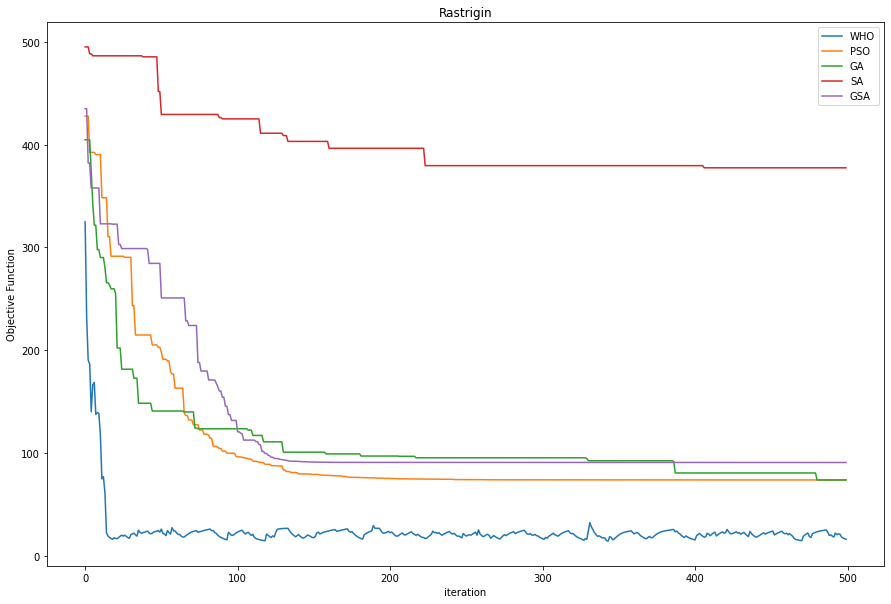

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(range(len(best_fitness_WHO)),best_fitness_WHO)
plt.plot(range(len(best_fitness_pso)),best_fitness_pso)

plt.plot(range(len(best_fitness_GA)),best_fitness_GA)

plt.plot(range(len(best_fitness_SA)),best_fitness_SA)
plt.plot(range(len(best_fitness_GSA)),best_fitness_GSA)

plt.legend(["WHO","PSO","GA","SA","GSA"])
plt.xlabel("iteration")
plt.ylabel("Objective Function")
plt.title("Rastrigin")
plt.show()

In [ ]:
df=pd.DataFrame({"WHO":best_fitness_list,"PSO":pso_best_fitnesses,"GA":best_fitnesses_GA})
# df.to_csv("/content/drive/MyDrive/EC project/rastrigin_EC_proj_df")

# Ackley

In [ ]:
def ackley(X):

    dim=len(X)

    t1=0
    t2=0
    for i in range (0,dim):
        t1+=X[i]**2
        t2+=math.cos(2*math.pi*X[i])     

    OF=20+math.e-20*math.exp((t1/dim)*-0.2)-math.exp(t2/dim)

    return OF

In [ ]:
lb=-32.768;ub=32.768
dim=30
varbound=np.array([[lb,ub]]*dim)

In [ ]:
population = create_population(pop_size,lb,ub,dim)
cp=calculate_fitnesses(population,"ackley")
xp_cp_dataframe = pd.DataFrame({'x_p':population.tolist(),'c_p':cp.tolist()})
best_fitness_WHO=wildbeast_optimizaiton(xp_cp_dataframe,ns,dim,etha,distance_from_crowding_threshold,distance_from_worst_threshold,ne,ph,alpha1,betta1,alpha2,betta2,function='ackley')

iteration # 0
iteration # 100
iteration # 200
iteration # 300
iteration # 400


## PSO

In [ ]:
best_position,best_fitness_pso = pso(ackley, max_iteration, pop_size, dim, lb,ub)

Iter = 10 best fitness = 21.297
Iter = 20 best fitness = 21.230
Iter = 30 best fitness = 21.230
Iter = 40 best fitness = 21.230
Iter = 50 best fitness = 21.109
Iter = 60 best fitness = 21.100
Iter = 70 best fitness = 21.100
Iter = 80 best fitness = 21.100
Iter = 90 best fitness = 21.083
Iter = 100 best fitness = 21.083
Iter = 110 best fitness = 21.034
Iter = 120 best fitness = 21.024
Iter = 130 best fitness = 20.964
Iter = 140 best fitness = 20.964
Iter = 150 best fitness = 20.935
Iter = 160 best fitness = 20.924
Iter = 170 best fitness = 20.924
Iter = 180 best fitness = 20.916
Iter = 190 best fitness = 20.888
Iter = 200 best fitness = 20.740
Iter = 210 best fitness = 20.679
Iter = 220 best fitness = 20.678
Iter = 230 best fitness = 20.678
Iter = 240 best fitness = 20.678
Iter = 250 best fitness = 20.678
Iter = 260 best fitness = 20.678
Iter = 270 best fitness = 20.639
Iter = 280 best fitness = 20.618
Iter = 290 best fitness = 20.595
Iter = 300 best fitness = 20.593
Iter = 310 best fit

## GA

In [ ]:


algorithm_param = {'max_num_iteration': 500,
                   'population_size':20}


model=ga(function=ackley,dimension=dim,variable_type='real',variable_boundaries=varbound)

model.run()
best_fitness_GA=model.report[:500]

## SA

In [ ]:
# seed the pseudorandom number generator
seed(1)
# define range for input
bounds = asarray([[lb, ub]]*30)
# define the total iterations
n_iterations = 500
# define the maximum step size
step_size = .1
# initial temperature
temp = 1
# perform the simulated annealing search
best, score, best_fitness_SA = simulated_annealing(ackley, bounds, n_iterations, step_size, temp)
print('Done!')
# print('f(%s) = %f' % (best, score))


Done!


## GSA

In [ ]:
best_fitness_GSA=GSA(ackley,lb,ub,30,20,500)

## plot ackley

In [ ]:
df=pd.read_csv(("/content/drive/MyDrive/EC project/ackley_EC_proj_df"))
best_fitness_WHO=df.WHO;best_fitness_pso=df.PSO;best_fitness_GA=df.GA

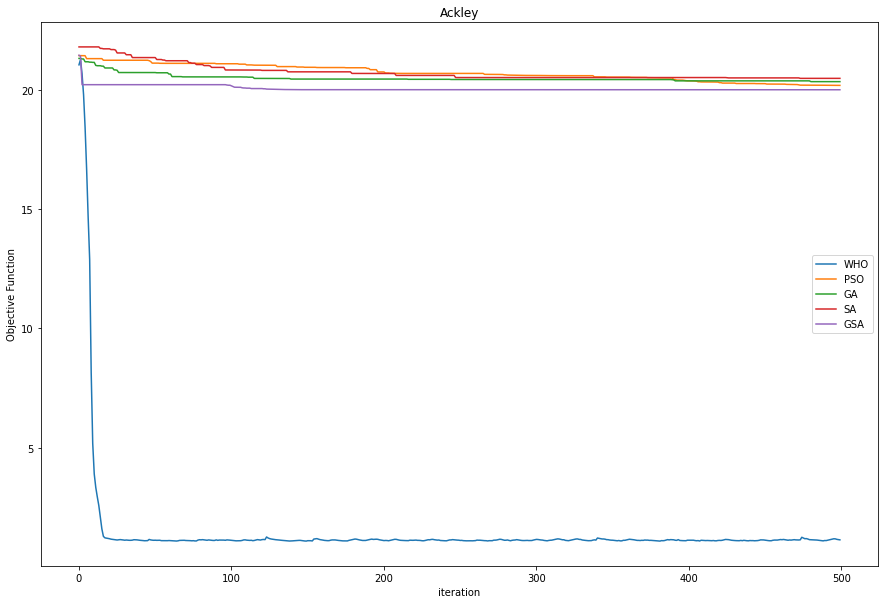

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(range(len(best_fitness_WHO)),best_fitness_WHO)
plt.plot(range(len(best_fitness_pso)),best_fitness_pso)
plt.plot(range(len(best_fitness_GA)),best_fitness_GA)
plt.plot(range(len(best_fitness_SA)),best_fitness_SA)
plt.plot(range(len(best_fitness_GSA)),best_fitness_GSA)

plt.legend(["WHO","PSO","GA","SA","GSA"])
plt.xlabel("iteration")
plt.ylabel("Objective Function")
plt.title("Ackley")
plt.show()

In [ ]:
df=pd.DataFrame({"WHO":best_fitness_WHO,"PSO":best_fitness_pso,"GA":best_fitness_GA})
# df=pd.DataFrame({"WHO":best_fitness_WHO})
# df.to_csv("/content/drive/MyDrive/EC project/ackley_EC_proj_df")

# Weierstras

In [ ]:

def weierstrass(X):

    dim=len(X) 

    a=0.5
    b=3
    OF=0
    for i in range (0,dim):
        t1=0
        for k in range (0,21):
            t1+=(a**k)*math.cos((2*math.pi*(b**k))*(X[i]+0.5))
        OF+=t1
    t2=0    
    for k in range (0,21):
        t2+=(a**k)*math.cos(math.pi*(b**k))
    OF-=dim*t2

    return OF


lb=-.5;ub=.5



In [ ]:

population = create_population(pop_size,lb,ub,dim)
cp=calculate_fitnesses(population,"weierstrass")
xp_cp_dataframe = pd.DataFrame({'x_p':population.tolist(),'c_p':cp.tolist()})
best_fitness_WHO=wildbeast_optimizaiton(xp_cp_dataframe,ns,dim,etha,distance_from_crowding_threshold,distance_from_worst_threshold,ne,ph,alpha1,betta1,alpha2,betta2,function='weierstrass')

iteration # 0
iteration # 100
iteration # 200
iteration # 300
iteration # 400


## PSO

In [ ]:
best_position,best_fitness_pso = pso(weierstrass, max_iteration, pop_size, dim, lb,ub)

Iter = 10 best fitness = 38.508
Iter = 20 best fitness = 29.355
Iter = 30 best fitness = 24.404
Iter = 40 best fitness = 21.987
Iter = 50 best fitness = 17.855
Iter = 60 best fitness = 14.711
Iter = 70 best fitness = 12.794
Iter = 80 best fitness = 11.914
Iter = 90 best fitness = 11.207
Iter = 100 best fitness = 9.649
Iter = 110 best fitness = 8.668
Iter = 120 best fitness = 7.728
Iter = 130 best fitness = 7.235
Iter = 140 best fitness = 6.684
Iter = 150 best fitness = 6.383
Iter = 160 best fitness = 5.693
Iter = 170 best fitness = 5.416
Iter = 180 best fitness = 5.023
Iter = 190 best fitness = 4.699
Iter = 200 best fitness = 4.427
Iter = 210 best fitness = 4.218
Iter = 220 best fitness = 4.130
Iter = 230 best fitness = 3.996
Iter = 240 best fitness = 3.700
Iter = 250 best fitness = 3.683
Iter = 260 best fitness = 3.601
Iter = 270 best fitness = 3.565
Iter = 280 best fitness = 3.514
Iter = 290 best fitness = 3.499
Iter = 300 best fitness = 3.472
Iter = 310 best fitness = 3.444
Iter = 3

## GA

 The best solution found:
 [-0.00450125  0.0025092  -0.03970027  0.00100041  0.01104369  0.00114688
  0.00195717 -0.0372435   0.03561044 -0.0051578  -0.04526145 -0.00293787
  0.00859605 -0.01009527 -0.0126705   0.0102228   0.01890197  0.03714611
 -0.00228432  0.00490227 -0.03571128 -0.00254813 -0.00069501  0.01037325
 -0.00410901 -0.03496439  0.04885717  0.00176484 -0.00652428 -0.02931271]

 Objective function:
 10.68974488563967


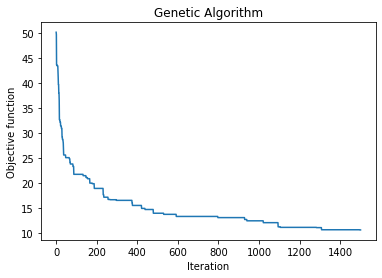

In [ ]:

varbound=np.array([[lb,ub]]*dim)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':20,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=weierstrass,dimension=dim,variable_type='real',variable_boundaries=varbound)

model.run()
best_fitness_GA=model.report[:500]

## SA

In [ ]:
# seed the pseudorandom number generator
seed(1)
# define range for input
bounds = asarray([[lb, ub]]*30)
# define the total iterations
n_iterations = 500
# define the maximum step size
step_size = .5
# initial temperature
temp = 1
# perform the simulated annealing search
best, score, best_fitness_SA = simulated_annealing(weierstrass, bounds, n_iterations, step_size, temp)
print('Done!')
# print('f(%s) = %f' % (best, score))


Done!


## GSA

In [ ]:
best_fitness_GSA=GSA(weierstrass,lb,ub,30,20,500)

## plot weierstrass

In [ ]:
df=pd.read_csv(("/content/drive/MyDrive/EC project/weierstrass_EC_proj_df"))
best_fitness_WHO=df.WHO;best_fitness_pso=df.PSO;best_fitness_GA=df.GA

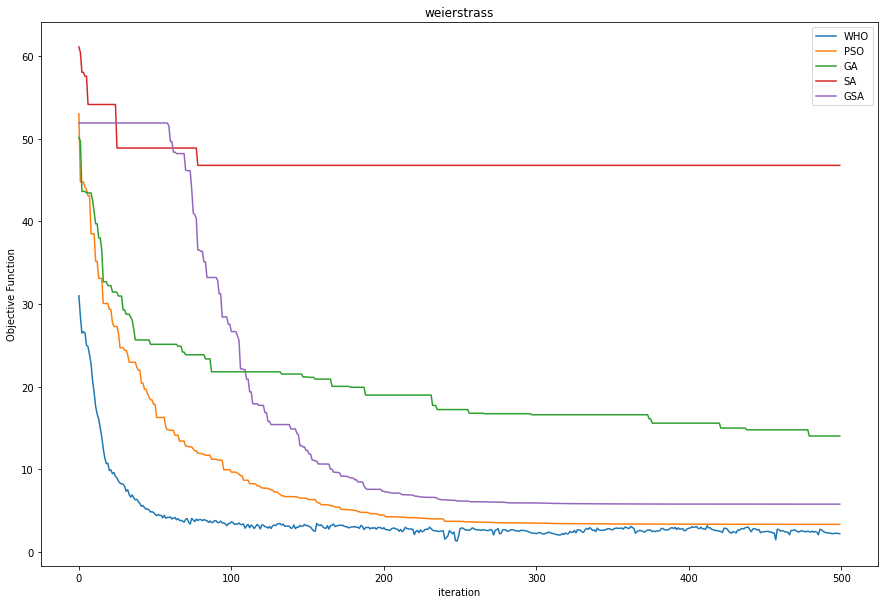

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(range(len(best_fitness_WHO)),best_fitness_WHO)
plt.plot(range(len(best_fitness_pso)),best_fitness_pso)

plt.plot(range(len(best_fitness_GA)),best_fitness_GA)
plt.plot(range(len(best_fitness_SA)),best_fitness_SA)
plt.plot(range(len(best_fitness_GSA)),best_fitness_GSA)

plt.legend(["WHO","PSO","GA","SA","GSA"])
plt.xlabel("iteration")
plt.ylabel("Objective Function")
plt.title("weierstrass")
plt.show()

In [ ]:
df=pd.DataFrame({"WHO":best_fitness_WHO,"PSO":best_fitness_pso,"GA":best_fitness_GA})
# df=pd.DataFrame({"WHO":best_fitness_WHO})
# df.to_csv("/content/drive/MyDrive/EC project/weierstrass_EC_proj_df")

# Sphere

In [ ]:
lb=-100;ub=100

population = create_population(pop_size,lb,ub,dim)
cp=calculate_fitnesses(population,"sphere")
xp_cp_dataframe = pd.DataFrame({'x_p':population.tolist(),'c_p':cp.tolist()})
best_fitness_WHO=wildbeast_optimizaiton(xp_cp_dataframe,ns,dim,etha,distance_from_crowding_threshold,distance_from_worst_threshold,ne,ph,alpha1,betta1,alpha2,betta2,function='sphere')

iteration # 0
iteration # 100
iteration # 200
iteration # 300
iteration # 400


In [ ]:

best_position,best_fitness_pso = pso(sphere1, max_iteration, pop_size, dim, lb,ub)

Iter = 10 best fitness = 22867.900
Iter = 20 best fitness = 8914.190
Iter = 30 best fitness = 8121.162
Iter = 40 best fitness = 5003.538
Iter = 50 best fitness = 4663.895
Iter = 60 best fitness = 3090.117
Iter = 70 best fitness = 2891.710
Iter = 80 best fitness = 1836.073
Iter = 90 best fitness = 1226.013
Iter = 100 best fitness = 978.518
Iter = 110 best fitness = 557.948
Iter = 120 best fitness = 353.753
Iter = 130 best fitness = 272.399
Iter = 140 best fitness = 250.439
Iter = 150 best fitness = 171.314
Iter = 160 best fitness = 103.324
Iter = 170 best fitness = 67.613
Iter = 180 best fitness = 47.910
Iter = 190 best fitness = 29.986
Iter = 200 best fitness = 13.399
Iter = 210 best fitness = 8.840
Iter = 220 best fitness = 7.653
Iter = 230 best fitness = 4.727
Iter = 240 best fitness = 3.518
Iter = 250 best fitness = 1.808
Iter = 260 best fitness = 1.791
Iter = 270 best fitness = 1.224
Iter = 280 best fitness = 0.867
Iter = 290 best fitness = 0.731
Iter = 300 best fitness = 0.484
Ite

 The best solution found:
 [-0.15549095 -0.31747538 -0.09248012 -0.04069694  0.03008365 -0.25808461
  0.55045706  0.91031516  0.00648962 -0.09200288  0.01915608  0.03121761
  0.14117007 -0.21145936 -0.14111846 -0.07182513 -0.33466978 -0.36848783
  0.04097024  0.01917075  0.19604211 -0.14267542  0.17291937  0.19908986
 -0.00645937 -0.02589827  0.16213237 -0.01062618 -0.2642263   0.45898236]

 Objective function:
 2.1196841765723793


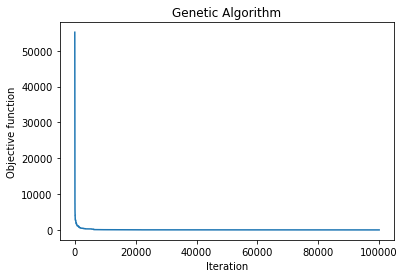

In [ ]:

varbound=np.array([[lb,ub]]*dim)

algorithm_param = {'max_num_iteration': 500,\
                   'population_size':20,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=sphere1,dimension=dim,variable_type='real',variable_boundaries=varbound)

model.run()
best_fitness_GA=model.report[:500]

## SA

In [ ]:
# seed the pseudorandom number generator
seed(1)
# define range for input
bounds = asarray([[-100, 100]]*30)
# define the total iterations
n_iterations = 500
# define the maximum step size
step_size = 10
# initial temperature
temp = 20
# perform the simulated annealing search
best, score, best_fitness_SA = simulated_annealing(sphere1, bounds, n_iterations, step_size, temp)
print('Done!')
# print('f(%s) = %f' % (best, score))


Done!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


## GSA

In [ ]:
best_fitness_GSA=GSA(sphere1,-100,100,30,20,500)

## plot GSA

In [ ]:
df=pd.read_csv(("/content/drive/MyDrive/EC project/sphere_EC_proj_df"))
best_fitness_WHO=df.WHO;best_fitness_pso=df.PSO;best_fitness_GA=df.GA

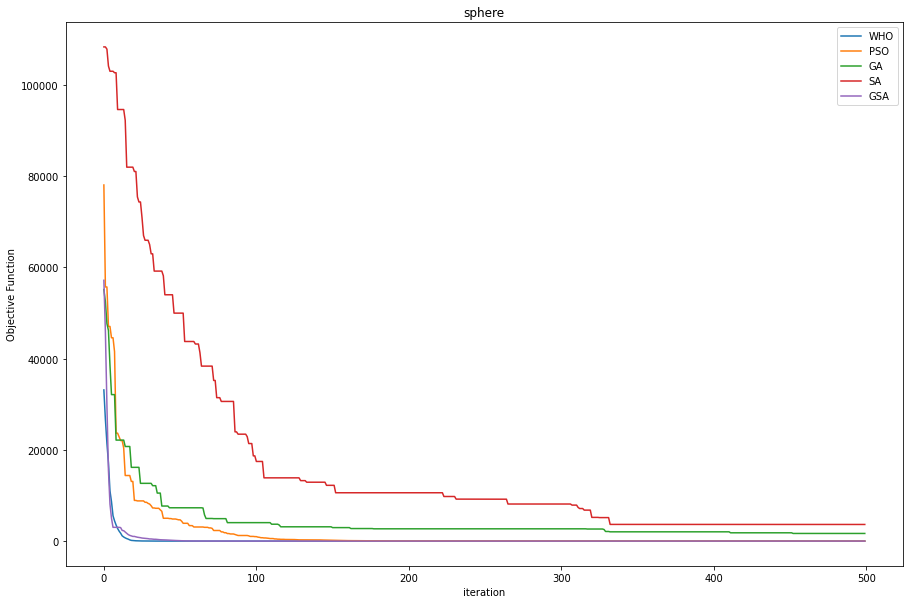

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(len(best_fitness_WHO)),best_fitness_WHO)
plt.plot(range(len(best_fitness_pso)),best_fitness_pso)

plt.plot(range(len(best_fitness_GA)),best_fitness_GA)
plt.plot(range(len(best_fitness_SA)),best_fitness_SA)
plt.plot(range(len(best_fitness_GSA)),best_fitness_GSA)

plt.legend(["WHO","PSO","GA","SA","GSA"])
plt.xlabel("iteration")
plt.ylabel("Objective Function")
plt.title("sphere")
plt.show()

In [ ]:
# df=pd.DataFrame({"WHO":best_fitness_WHO,"PSO":best_fitness_pso,"GA":best_fitness_GA})
# df=pd.DataFrame({"WHO":best_fitness_WHO})
# df.to_csv("/content/drive/MyDrive/EC project/sphere_EC_proj_df")

# mean std

In [ ]:
dim=5
ns=2*dim
ne=25
etha=.05
alpha1,betta1=.9,.3
alpha2,betta2=.2,.8
distance_from_worst_threshold=10
distance_from_crowding_threshold=10
pop_size= 20;
ph=.2
max_iteration = 100
lb=-100;ub=100

In [ ]:

best_position_in_every_run_WHO=[]
for i in range(50):
  population = create_population(pop_size,lb,ub,dim)
  cp=calculate_fitnesses(population,"sphere")
  xp_cp_dataframe = pd.DataFrame({'x_p':population.tolist(),'c_p':cp.tolist()})
  best_fitness_WHO=wildbeast_optimizaiton(xp_cp_dataframe,ns,dim,etha,distance_from_crowding_threshold,distance_from_worst_threshold,ne,ph,alpha1,betta1,alpha2,betta2,function='sphere')
  best_position_in_every_run_WHO.append(best_fitness_WHO)

In [ ]:

# best_position_in_every_run_WHO=best_position_in_every_run_WHO.tolist()
best_position_in_every_run_WHO_=[best_position_in_every_run_WHO[i][-1] for i in range(len(best_position_in_every_run_WHO))]
best_position_in_every_run_WHO_

In [ ]:
st_dev_WHO = statistics.pstdev(best_position_in_every_run_WHO_)
mean_WHO = mean(best_position_in_every_run_WHO_)
median_WHO = statistics.median(best_position_in_every_run_WHO_)

print(f"mean: {mean_WHO} \t median: {median_WHO} \t std: {st_dev_WHO}")

mean: 0.028928277817989435 	 median: 0.028531667382560036 	 std: 0.006531271205816313


In [ ]:
best_position_in_every_run_PSO=[]
for i in range(50):
  best_position,best_fitness_pso = pso(sphere1, max_iteration, pop_size, dim, lb,ub)
  best_position_in_every_run_PSO.append(best_fitness_pso)

In [ ]:
best_position_in_every_run_PSO_=[best_position_in_every_run_PSO[i][-1] for i in range(len(best_position_in_every_run_PSO))]

In [ ]:
best_position_in_every_run_PSO

In [ ]:
st_dev_PSO = statistics.pstdev(best_position_in_every_run_PSO_)
mean_PSO = mean(best_position_in_every_run_PSO_)
median_PSO = statistics.median(best_position_in_every_run_PSO_)

print(f"mean: {mean_PSO} \t median: {median_PSO} \t std: {st_dev_PSO}")

mean: 1.6825364242556867e-09 	 median: 1.6825364242556884e-09 	 std: 0.0


 The best solution found:
 [-3.48279317e-07 -1.51198900e-05  2.95915733e-06 -9.44572372e-06
  2.57769844e-05]

 Objective function:
 9.911636068506637e-10


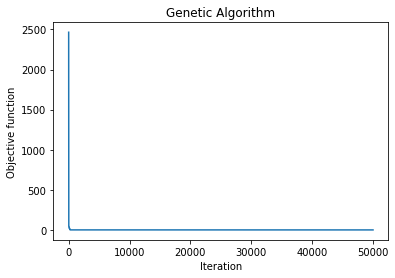

 The best solution found:
 [ 1.14567865e-05  8.14284654e-05  4.21127274e-04  2.82081527e-05
 -1.65048928e-04]

 Objective function:
 2.1214688229575396e-07


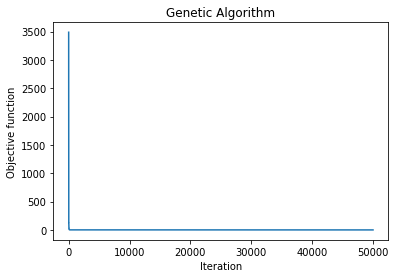

 The best solution found:
 [ 4.77232445e-05 -1.92750095e-06 -2.00347154e-05 -1.56315742e-04
 -3.44889175e-07]

 Objective function:
 2.7117343238114306e-08


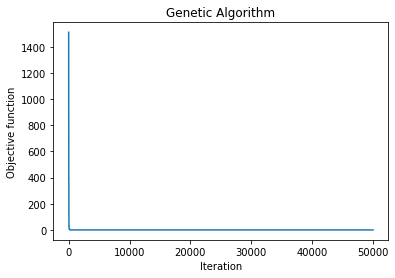

||||||||||||||||||||||||||||||||||||||||__________ 79.9% GA is running...

KeyboardInterrupt: ignored

In [ ]:
varbound=np.array([[lb,ub]]*dim)

algorithm_param = {'max_num_iteration': 100,\
                   'population_size':20,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}
best_position_in_every_run_GA   =[]                
for i in range(50):
  model=ga(function=sphere1,dimension=dim,variable_type='real',variable_boundaries=varbound)

  model.run()
  best_fitness_GA=model.report[:500]
  best_position_in_every_run_GA.append(best_fitness_GA)

In [ ]:
seed(1)
# define range for input
bounds = asarray([[-100, 100]]*5)
# define the total iterations
n_iterations = 500
# define the maximum step size
step_size = 10
# initial temperature
temp = 20
# perform the simulated annealing search
best_position_in_every_run_SA=[]
for i in range(50):
  best, score, best_fitness_SA = simulated_annealing(sphere1, bounds, n_iterations, step_size, temp)
  best_position_in_every_run_SA.append(best_fitness_SA)
  print('Done!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


In [ ]:
best_position_in_every_run_SA_=[best_position_in_every_run_SA[i][-1] for i in range(len(best_position_in_every_run_SA))]

In [ ]:
st_dev_SA = statistics.pstdev(best_position_in_every_run_SA_)
mean_SA = mean(best_position_in_every_run_SA_)
median_SA = statistics.median(best_position_in_every_run_SA_)

print(f"mean: {mean_SA} \t median: {median_SA} \t std: {st_dev_SA}")

mean: 30.488334505807792 	 median: 31.897808403180754 	 std: 14.20745485358927


In [ ]:
best_position_in_every_run_GSA=[]
for i in range(50):
  best_fitness_GSA=GSA(sphere1,-100,100,5,20,100)
  best_position_in_every_run_GSA.append(best_fitness_GSA)

In [ ]:
best_position_in_every_run_GSA_=[best_position_in_every_run_GSA[i][-1] for i in range(len(best_position_in_every_run_GSA))]

In [ ]:
st_dev_GSA = statistics.pstdev(best_position_in_every_run_GSA_)
mean_GSA = mean(best_position_in_every_run_GSA_)
median_GSA = statistics.median(best_position_in_every_run_GSA_)

print(f"mean: {mean_GSA} \t median: {median_GSA} \t std: {st_dev_GSA}")

mean: 54.880756339339456 	 median: 19.072088155832496 	 std: 122.12059895267
